# Generate Probability of Detection for Operators
Code author: Sahar H. El Abbadi
Date started: 2022-02-23
Date last edited: 2022-03-01

In [1]:
# Setup

# Imports

from plot_methods import plot_detection_limit

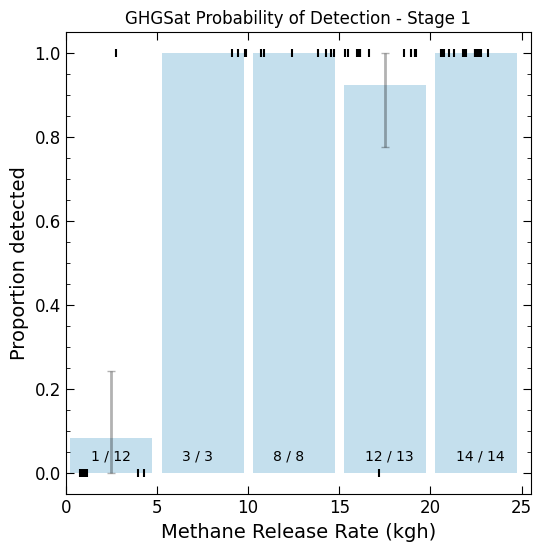

In [2]:
# GHGSat probability of detection
operator = 'GHGSat'
stage = 1
strict_discard = False
n_bins = 5
threshold = 25
plot_detection_limit(operator, stage, strict_discard, n_bins, threshold)

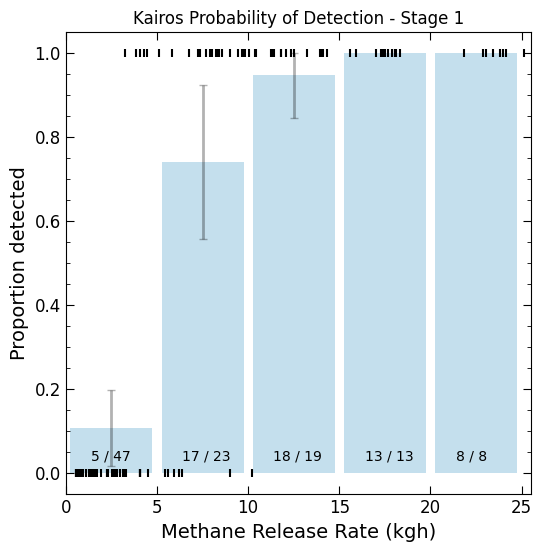

In [3]:
# Kairos probability of detection
operator = 'Kairos'
stage = 1
n_bins = 5
threshold = 25
plot_detection_limit(operator, stage, n_bins=n_bins, threshold=threshold, strict_discard=False)

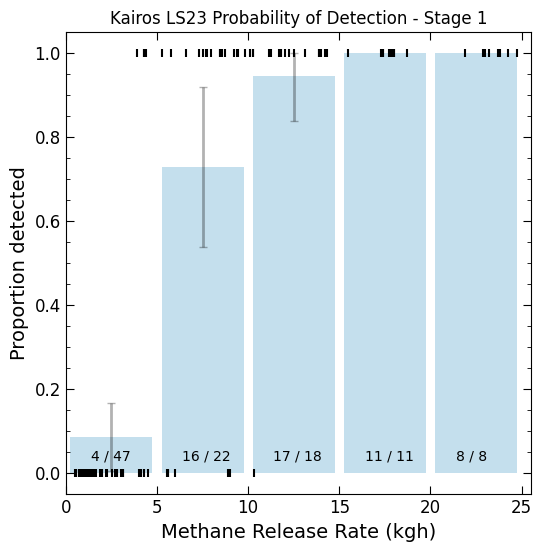

In [4]:
# Kairos probability of detection
operator = 'Kairos LS23'
stage = 1
n_bins = 5
threshold = 25
plot_detection_limit(operator, stage, n_bins=n_bins, threshold=threshold, strict_discard=False)

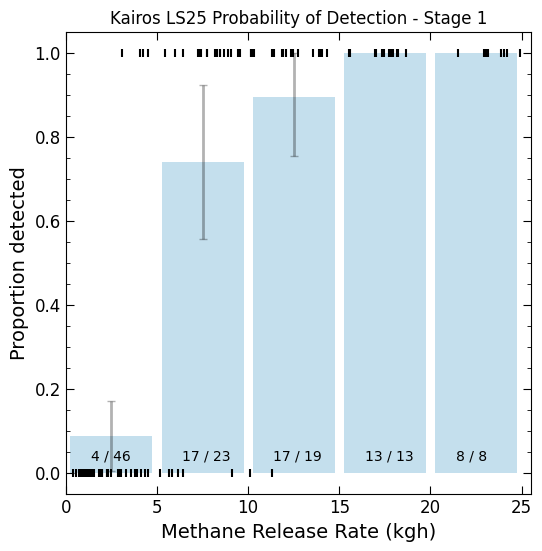

In [5]:
# Kairos probability of detection
operator = 'Kairos LS25'
stage = 1
n_bins = 5
threshold = 25
plot_detection_limit(operator, stage, n_bins=n_bins, threshold=threshold, strict_discard=False)

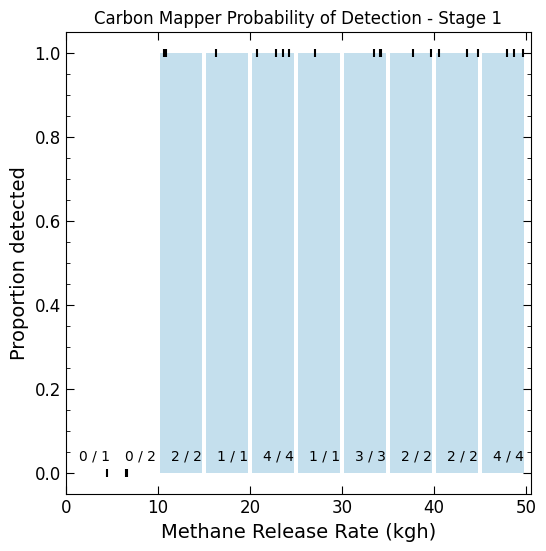

In [6]:
# Carbon Mapper probability of detection
operator = 'Carbon Mapper'
stage = 1
n_bins = 10
threshold = 50
plot_detection_limit(operator, stage, n_bins=n_bins, threshold=threshold, strict_discard=False)